# **Project2. Molecular property prediction using GCN**

Dataset: HIV


# **Library + hyperparameter setup**

In [1]:
# install rdkit and deepchem on colab environment
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem=2.1.0 python=3.6
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages/')

--2019-12-22 10:55:36--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71785000 (68M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  68.46M   153MB/s    in 0.4s    

2019-12-22 10:55:37 (153 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [71785000/71785000]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.2.0=py37_0
    - ca-certificates==2019.10.16=0
    - certifi==2019.9.11=py37_0
    - cffi==1.13.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b6447c_0
  

In [2]:
# import libraries
import deepchem as dc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

import time
import math
import numpy as np
import scipy.sparse as sp
import networkx as nx
from rdkit import Chem
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc #for ECFP
from sklearn.ensemble import RandomForestClassifier #for ECFP
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

# set hyperparameters
# HIV setting
hp = {}
hp['learning_rate'] = 1e-5
hp['epochs'] = 5
hp['batch_size'] = 128
hp['hidden1'] = 64
hp['hidden2'] = 128
hp['hidden3'] = 256
hp['hidden4'] = 512
hp['dropout'] = 0.2

print(hp)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

{'learning_rate': 1e-05, 'epochs': 5, 'batch_size': 128, 'hidden1': 64, 'hidden2': 128, 'hidden3': 256, 'hidden4': 512, 'dropout': 0.2}


# **Helper functions for GCN data handling**

In [0]:
def load_lists(dataset):
  # load data
  adj_list = []
  feat_list = []
  label_list = []
  
  for x, y, w, smiles in dataset.itersamples():

    smiles = Chem.MolFromSmiles(smiles)
    featurizer = dc.feat.ConvMolFeaturizer()
    features = featurizer.featurize([smiles])[0]

    edge_list = features.get_adjacency_list()
    atom_feature = features.get_atom_features() 

    # convert adjacency list into adjacency matrix "A"
    adj = np.zeros((len(edge_list), len(edge_list)))
    for i in range(len(edge_list)):
      for j in edge_list[i]:
        adj[i][j]=1
    adj_list.append(adj) # (num_atoms, num_atoms)
    feat_list.append(atom_feature) # (num_atoms, num_features=75)
    label_list.append(y) # 0/1

  return adj_list, feat_list, label_list

# f(H(l), A) = nonlinear(Dhat^-1/2 * Ahat * Dhat^-1/2 * H_l * W_l)
# preprocessing for recurrent interaction during convolution
def normalize_adj(adj):
  # add identity matrix
  adj_hat = adj + np.eye(adj.shape[0])
  # compute diagonal node degree matrix of Ahat
  deg = np.sum(adj_hat,axis=0)

  # sqrt inv
  deg_inv = np.divide(1, deg)
  deg_inv_sqrt = np.sqrt(deg_inv)
  deg_inv_diag = np.diag(np.squeeze(np.asarray(deg_inv_sqrt)))

  # normalize
  adj_norm = np.matmul(np.matmul(deg_inv_diag, adj_hat), deg_inv_diag)
  return adj_norm

In [0]:
# custom dataset class
class BaseDataset(Dataset):
  def __init__(self, adj_list, feat_list, label_list, train_mode=False):
    self.adj_list = adj_list
    self.feat_list = feat_list
    self.label_list = label_list
    self.train_mode = train_mode

  def __len__(self):
    return len(self.adj_list)
  
  def __getitem__(self, idx):
    # return graph, feature and label
    return adj_list[idx], feat_list[idx], label_list[idx]

  def get_tensors(self):
    # return batch tensors of normalized adjacency matrix, input and target
    # return tensor shape (batch_size, *)
    adj_list = self.adj_list
    feat_list = self.feat_list
    label_list = self.label_list

    # get maximum size for padding
    max_num_atom = -1
    for adj in adj_list:
      if adj.shape[0] > max_num_atom:
        max_num_atom = adj.shape[0]
    
    # make padded batch matrix of normalized adjacency matrix
    padded_adj_list = []
    for i, adj in enumerate(adj_list): # (num_atoms, num_atoms)
      adj_norm = normalize_adj(adj) # normalize
      # padding
      pad_num = max_num_atom - adj.shape[0]
      npad = ((0, pad_num), (0, pad_num))
      padded_adj = np.pad(adj_norm, npad, mode='constant', constant_values=0)
      # append
      padded_adj_list.append(padded_adj)
    # construct numpy array
    adj_np = np.stack(padded_adj_list, axis=0) # (batch_size, num_atoms, num_atoms)

    # make padded batch matrix of feature matrix
    padded_feat_list = []
    for i, feat in enumerate(feat_list): # (num_atoms, num_features=75)
      # padding
      pad_num = max_num_atom - feat.shape[0]
      npad = ((0, pad_num), (0, 0))
      padded_feat = np.pad(feat, npad, mode='constant', constant_values=0)
      # append
      padded_feat_list.append(padded_feat)
    # construct numpy array
    feat_np = np.stack(padded_feat_list, axis=0) # (batch_size, num_atoms, num_features=75)
    feat_np = np.transpose(feat_np, [0, 2, 1]) # (batch_size, num_features=75, num_atoms)

    # convert label list to numpy array
    label_np = np.asarray(label_list)

    adjs = torch.from_numpy(adj_np)
    inputs = torch.from_numpy(feat_np)
    targets = torch.from_numpy(label_np)

    del adj_list, feat_list, label_list, padded_adj_list, padded_feat_list

    return adjs, inputs, targets

In [0]:
# dataset constructor
def make_dataset(batch_size, adj_list, feat_list, label_list):
  # construct BaseDataset objects for each batch
  data_len = len(adj_list)

  begin = 0
  finished = 0
  dataset_list = []
  while(1):
    if begin + batch_size < data_len:
      end = begin + batch_size
      dataset_list.append(BaseDataset(adj_list[begin:end],
                                      feat_list[begin:end],
                                      label_list[begin:end],
                                      train_mode=True))
      begin += batch_size
    else:
      end = data_len
      dataset_list.append(BaseDataset(adj_list[begin:end],
                                      feat_list[begin:end],
                                      label_list[begin:end],
                                      train_mode=True))
      break
  return  math.ceil(data_len/batch_size), dataset_list

# **GCN model code**

In [0]:
# graph convolution layer
class GraphConvolution(nn.Module):
  def __init__(self, input_dim, output_dim, dropout=0):
    super().__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.p = dropout
    
    # feature weight matrix
    self.w = nn.Parameter(torch.empty(output_dim, input_dim))
    nn.init.xavier_uniform_(self.w)
    self.relu = nn.ReLU() # non-linearity
    self.dropout = nn.Dropout(p=self.p) # dropout

  def forward(self, x, adjs):
    # input, output tensor shapes: (batch_size, num_features, num_nodes)
    # adjs tensor shape: (batch_size, num_nodes, num_nodes)
    num_nodes = x.shape[2]
    if x.shape[1] != self.input_dim:
      print((x.shape[1], self.input_dim))
      raise RuntimeError("input feature dimension not matched to input_dim argument")

    x = x.type(torch.FloatTensor)
    adjs = adjs.type(torch.FloatTensor)

    # forward
    x = self.dropout(x)
    x = torch.transpose(x, 1, 2) # (batch_size, num_nodes, input_dim)
    w = torch.transpose(self.w, 0, 1) # (input_dim, output_dim)
    x = torch.einsum("abc,cd->abd", (x, w)) # (batch_size, num_nodes, output_dim)
    x = torch.transpose(x, 1, 2) # (batch_size, output_dim, num_nodes)
    o = torch.bmm(x, adjs) # (batch_size, output_dim, num_nodes)
    return o

class GCNModel(nn.Module):
  def __init__(self, input_dim):
    super().__init__()
    self.input_dim = input_dim
    self.hp = hp # hyperparameters
    hidden1 = self.hp['hidden1']
    hidden2 = self.hp['hidden2']
    hidden3 = self.hp['hidden3']
    hidden4 = self.hp['hidden4']
    p = self.hp['dropout']

    self.gc1 = GraphConvolution(input_dim=self.input_dim, output_dim=hidden1, dropout=p)
    self.gc2 = GraphConvolution(input_dim=hidden1, output_dim=hidden2, dropout=p)
    self.gc3 = GraphConvolution(input_dim=hidden2, output_dim=hidden3, dropout=p)
    self.gc4 = GraphConvolution(input_dim=hidden3, output_dim=hidden4, dropout=p)

    self.bn1 = nn.BatchNorm1d(num_features=hidden1)
    self.bn2 = nn.BatchNorm1d(num_features=hidden2)
    self.bn3 = nn.BatchNorm1d(num_features=hidden3)
    self.bn4 = nn.BatchNorm1d(num_features=hidden4)
    self.bn_fc = nn.BatchNorm1d(num_features=1)

    self.fc = nn.Linear(in_features=hidden4, out_features=1)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=p)
    self.dropout_fc = nn.Dropout(p=0.5)
    
  def forward(self, x, adjs):
    # input tensor shape: (batch_size, input_dim, num_nodes)
    x = self.relu(self.dropout(self.bn1(self.gc1(x, adjs))))
    x = self.relu(self.dropout(self.bn2(self.gc2(x, adjs))))
    x = self.relu(self.dropout(self.bn3(self.gc3(x, adjs))))
    x = self.relu(self.dropout(self.bn4(self.gc4(x, adjs))))
    x = self.fc(self.dropout_fc(torch.mean(x, dim=2)))
    o = self.bn_fc(x)
    # output tensor shape: (batch_size, output_dim=1)
    return o

In [0]:
def train(model, train_batch_num, train_dataset_list, criterion):
  train_roc_score = 0.
  train_ap_score = 0.
  cnt = 0
  epoch_loss = 0.
  for idx in range(train_batch_num):
    train_dataset = train_dataset_list[idx]
    adjs, inputs, targets = train_dataset.get_tensors()
    output = model(inputs, adjs)

    loss = criterion(output, targets)
    epoch_loss += loss.item()
    loss.backward()
    optimizer.step()

    targets = targets.clone().detach().numpy()
    output = output.clone().detach().numpy()
    output = 1 / (1 + np.exp(-output)) # sigmoid
    output = output > 0.5
    try:
      train_roc_score += roc_auc_score(targets, output)
      train_ap_score += average_precision_score(targets, output)
      cnt += 1
    except ValueError:
      pass
  
  train_roc_score /= cnt
  train_ap_score /= cnt
  epoch_loss /= train_batch_num
  return train_roc_score, train_ap_score, epoch_loss

def evaluate(valid_batch_num, model, valid_dataset_list):
  roc_score = 0.
  ap_score = 0.
  cnt = 0
  for idx in range(valid_batch_num):
    valid_dataset = valid_dataset_list[idx]
    adjs, inputs, targets = valid_dataset.get_tensors()
    output = model(inputs, adjs)

    targets = targets.clone().detach().numpy()
    output = output.clone().detach().numpy()
    output = 1 / (1 + np.exp(-output)) # sigmoid
    output = output > 0.5
    try:
      roc_score += roc_auc_score(targets, output)
      ap_score += average_precision_score(targets, output)
      cnt += 1
    except ValueError:
      pass
  
  roc_score /= cnt
  ap_score /= cnt
  return roc_score, ap_score

# **ECFP - random forest model**

In [0]:
### make helper functions for ECFP featurization ###
# function for getting ECFP feature
# input: train, validation, or test dataset
def loadECFP(dataset):
  # load data
  ECFP_feat = []
  ECFP_label = []
  for x, y, w, smiles in dataset.itersamples():
    ECFP_feat.append(x)
    ECFP_label.append(y)
  # return ECFP feature and its label (X___, Y___)
  return np.array(ECFP_feat), np.array(ECFP_label)

# ECFP model building funcion
# Randomly splitted data are used
def getAUCfromRF_model(X_train, Y_train, X_test, Y_test):
  # make randomforest classifier
  clf=RandomForestClassifier(n_estimators=100, criterion='entropy')
  # train with train set
  clf.fit(X_train, Y_train)
  fpr, tpr, thresholds = roc_curve(Y_test, clf.predict_proba(X_test)[:, 1])
  # get auc score with test sets
  AUC = auc(fpr, tpr)
  return(AUC)

# **Main routine**

ours / HIV benchmark result

<div>
<img src=https://drive.google.com/uc?export=download&id=18lhC9JhPrxVkbsFx6xAk1sydA6mjN4AW
 height="200"/>
<img src=https://drive.google.com/uc?export=download&id=1g8WkcrB4OVC2bZjR3hBuKJgO0x_UKx3- height="200"/>
</div>

In [9]:
# loop routine
seed_list = [33,84,35,31,48,42,59,53,54,51]
GCN_AUC_list = []
ECFP_AUC_list = []

for i in range(10):
  # set random seed
  seed = seed_list[i]
  np.random.seed(seed)
  torch.manual_seed(seed)

  # load dataset
  tasks, datasets, transformers = dc.molnet.load_bace_classification(featurizer='ECFP',
                                                                     split='scaffold')
  train_dataset, valid_dataset, test_dataset = datasets
  
  ###########################################################
  # GCN section
  ###########################################################

  # load lists
  train_adj_list, train_feat_list, train_label_list = load_lists(train_dataset)
  valid_adj_list, valid_feat_list, valid_label_list = load_lists(valid_dataset)
  test_adj_list, test_feat_list, test_label_list = load_lists(test_dataset)
  
  # construct datasets
  train_batch_num, train_dataset_list = make_dataset(batch_size = hp['batch_size'],
                                                     adj_list=train_adj_list,
                                                     feat_list=train_feat_list,
                                                     label_list=train_label_list)
  valid_batch_num, valid_dataset_list = make_dataset(batch_size = hp['batch_size'],
                                                     adj_list=valid_adj_list,
                                                     feat_list=valid_feat_list,
                                                     label_list=valid_label_list)
  test_batch_num, test_dataset_list = make_dataset(batch_size = hp['batch_size'],
                                                   adj_list=test_adj_list,
                                                   feat_list=test_feat_list,
                                                   label_list=test_label_list)
  # main training routine
  # define model
  num_features = train_feat_list[0].shape[1]
  model = GCNModel(input_dim = num_features)
  
  # set optimizer and loss
  optimizer = optim.Adam(model.parameters(), lr=hp['learning_rate'])
  criterion = nn.BCEWithLogitsLoss(reduction='mean')
  
  # optimization
  print("\ntrain start: %d" %(i+1))
  for epoch in range(hp['epochs']):
    t = time.time()
    model.train()
    train_roc_score, train_ap_score, epoch_loss = train(model,
                                                        train_batch_num,
                                                        train_dataset_list,
                                                        criterion)
    model.eval()
    roc_score, ap_score = evaluate(valid_batch_num, model, valid_dataset_list)
    print("epoch:", '%02d' % (epoch + 1),
          "train: [loss=", "{:.4f}".format(epoch_loss),
          "roc=", "{:.4f}".format(train_roc_score),
          "ap=", "{:.4f}".format(train_ap_score),
          "] val: [roc=", "{:.4f}".format(roc_score),
          "ap=", "{:.4f}".format(ap_score),
          "] t=", "{:.4f}".format(time.time() - t))
    
  print('optimization finished!')
  model.eval()
  roc_score, ap_score = evaluate(test_batch_num, model, test_dataset_list)
  print('Test ROC score: {:.5f}'.format(roc_score))
  print('Test AP score: {:.5f}'.format(ap_score))
  GCN_AUC_list.append(roc_score)

  del model, train_dataset_list, valid_dataset_list, test_dataset_list
  del tasks, datasets, transformers
  del train_adj_list, train_feat_list, train_label_list
  del valid_adj_list, valid_feat_list, valid_label_list
  del test_adj_list, test_feat_list, test_label_list

  ###########################################################
  # ECFP - random forest section
  ###########################################################

  # train, test data for ECFP
  X_train_E, Y_train_E = loadECFP(train_dataset)
  X_test_E, Y_test_E = loadECFP(test_dataset)
  
  # AUC list for ECFP
  ECFP_AUC = getAUCfromRF_model(X_train_E, Y_train_E, X_test_E, Y_test_E)
  ECFP_AUC_list.append(ECFP_AUC)

  del train_dataset, valid_dataset, test_dataset
  del X_train_E, Y_train_E, X_test_E, Y_test_E

Loading raw samples now.
shard_size: 8192
About to start loading CSV from /tmp/bace.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 0 took 3.845 s
TIMING: dataset construction took 4.089 s
Loading dataset from disk.
TIMING: dataset construction took 0.077 s
Loading dataset from disk.
TIMING: dataset construction took 0.072 s
Loading dataset from disk.
TIMING: dataset construction took 0.041 s
Loading dataset from disk.
TIMING: dataset construction took 0.037 s
Loading dataset from disk.

train start: 1
epoch: 01 train: [loss= 0.8045 roc= 0.5040 ap= 0.5156 ] val: [roc= 0.5000 ap= 0.6562 ] t= 4.0973
epoch: 02 train: [loss= 0.8072 roc= 0.4523 ap= 0.4921 ] val: [roc= 0.4816 ap= 0.6481 ] t= 3.7839
epoch: 03 train: [loss= 0.8123 roc= 0.4465 ap= 0.4905 ] val: [roc= 0.5779 ap= 0.6964 ] t= 3.8303
epoch: 04 train: [loss= 0.8074 roc= 0.4763 ap= 0.5035 ] val: [roc= 0.5693 ap= 0.6935 ] t= 3.8548
epoch: 05 train: [loss= 0.8055 roc= 0.5056 ap= 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.

train start: 2
epoch: 01 train: [loss= 0.8139 roc= 0.4767 ap= 0.5017 ] val: [roc= 0.4832 ap= 0.6524 ] t= 3.7801
epoch: 02 train: [loss= 0.8019 roc= 0.4839 ap= 0.5062 ] val: [roc= 0.4821 ap= 0.6483 ] t= 3.7502
epoch: 03 train: [loss= 0.8066 roc= 0.4999 ap= 0.5136 ] val: [roc= 0.5211 ap= 0.6659 ] t= 3.8009
epoch: 04 train: [loss= 0.7976 roc= 0.5443 ap= 0.5335 ] val: [roc= 0.5233 ap= 0.6671 ] t= 3.7303
epoch: 05 train: [loss= 0.7919 roc= 0.5479 ap= 0.5365 ] val: [roc= 0.4832 ap= 0.6524 ] t= 3.7207
optimization finished!
Test ROC score: 0.50735
Test AP score: 0.53814


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.

train start: 3
epoch: 01 train: [loss= 0.8098 roc= 0.5033 ap= 0.5136 ] val: [roc= 0.5000 ap= 0.6562 ] t= 3.7481
epoch: 02 train: [loss= 0.8113 roc= 0.4615 ap= 0.4955 ] val: [roc= 0.4848 ap= 0.6502 ] t= 3.7254
epoch: 03 train: [loss= 0.8064 roc= 0.5107 ap= 0.5167 ] val: [roc= 0.4784 ap= 0.6488 ] t= 3.6992
epoch: 04 train: [loss= 0.8068 roc= 0.4991 ap= 0.5118 ] val: [roc= 0.5146 ap= 0.6633 ] t= 3.6893
epoch: 05 train: [loss= 0.8015 roc= 0.4822 ap= 0.5058 ] val: [roc= 0.5184 ap= 0.6668 ] t= 3.7520
optimization finished!
Test ROC score: 0.50735
Test AP score: 0.53814


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.

train start: 4
epoch: 01 train: [loss= 0.8118 roc= 0.4696 ap= 0.4988 ] val: [roc= 0.5000 ap= 0.6562 ] t= 3.6607
epoch: 02 train: [loss= 0.8064 roc= 0.5010 ap= 0.5125 ] val: [roc= 0.5000 ap= 0.6562 ] t= 3.7343
epoch: 03 train: [loss= 0.8057 roc= 0.4958 ap= 0.5112 ] val: [roc= 0.5000 ap= 0.6562 ] t= 3.7120
epoch: 04 train: [loss= 0.8018 roc= 0.5049 ap= 0.5149 ] val: [roc= 0.5000 ap= 0.6562 ] t= 3.7590
epoch: 05 train: [loss= 0.8022 roc= 0.4616 ap= 0.4969 ] val: [roc= 0.5000 ap= 0.6562 ] t= 3.7242
optimization finished!
Test ROC score: 0.50000
Test AP score: 0.53125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.

train start: 5
epoch: 01 train: [loss= 0.8175 roc= 0.4634 ap= 0.5055 ] val: [roc= 0.5000 ap= 0.6562 ] t= 3.6260
epoch: 02 train: [loss= 0.8073 roc= 0.5006 ap= 0.5125 ] val: [roc= 0.5000 ap= 0.6562 ] t= 3.6732
epoch: 03 train: [loss= 0.8141 roc= 0.4819 ap= 0.5052 ] val: [roc= 0.5000 ap= 0.6562 ] t= 3.6353
epoch: 04 train: [loss= 0.8095 roc= 0.4678 ap= 0.4986 ] val: [roc= 0.5000 ap= 0.6562 ] t= 3.6517
epoch: 05 train: [loss= 0.7958 roc= 0.5475 ap= 0.5349 ] val: [roc= 0.4762 ap= 0.6457 ] t= 3.6548
optimization finished!
Test ROC score: 0.59755
Test AP score: 0.58762


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.

train start: 6
epoch: 01 train: [loss= 0.7963 roc= 0.5532 ap= 0.5408 ] val: [roc= 0.4935 ap= 0.6533 ] t= 3.6225
epoch: 02 train: [loss= 0.8038 roc= 0.5217 ap= 0.5236 ] val: [roc= 0.4589 ap= 0.6384 ] t= 3.6337
epoch: 03 train: [loss= 0.8055 roc= 0.5182 ap= 0.5203 ] val: [roc= 0.5904 ap= 0.7031 ] t= 3.6035
epoch: 04 train: [loss= 0.8084 roc= 0.4748 ap= 0.5017 ] val: [roc= 0.5038 ap= 0.6580 ] t= 3.6769
epoch: 05 train: [loss= 0.8009 roc= 0.4935 ap= 0.5091 ] val: [roc= 0.5016 ap= 0.6570 ] t= 3.5978
optimization finished!
Test ROC score: 0.52941
Test AP score: 0.55882


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.

train start: 7
epoch: 01 train: [loss= 0.8080 roc= 0.5034 ap= 0.5219 ] val: [roc= 0.5000 ap= 0.6562 ] t= 3.6772
epoch: 02 train: [loss= 0.8088 roc= 0.4933 ap= 0.5093 ] val: [roc= 0.5000 ap= 0.6562 ] t= 3.6871
epoch: 03 train: [loss= 0.8106 roc= 0.4772 ap= 0.5029 ] val: [roc= 0.5000 ap= 0.6562 ] t= 3.6472
epoch: 04 train: [loss= 0.8038 roc= 0.5376 ap= 0.5305 ] val: [roc= 0.4589 ap= 0.6384 ] t= 3.6737
epoch: 05 train: [loss= 0.8142 roc= 0.4556 ap= 0.4972 ] val: [roc= 0.5135 ap= 0.6625 ] t= 3.5753
optimization finished!
Test ROC score: 0.53382
Test AP score: 0.55431


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.

train start: 8
epoch: 01 train: [loss= 0.8058 roc= 0.5042 ap= 0.5137 ] val: [roc= 0.4816 ap= 0.6481 ] t= 3.5973
epoch: 02 train: [loss= 0.8043 roc= 0.5245 ap= 0.5243 ] val: [roc= 0.5179 ap= 0.6685 ] t= 3.5746
epoch: 03 train: [loss= 0.8132 roc= 0.4917 ap= 0.5125 ] val: [roc= 0.5254 ap= 0.6697 ] t= 3.6280
epoch: 04 train: [loss= 0.7981 roc= 0.5462 ap= 0.5351 ] val: [roc= 0.5200 ap= 0.6663 ] t= 3.6014
epoch: 05 train: [loss= 0.7869 roc= 0.6156 ap= 0.5751 ] val: [roc= 0.5092 ap= 0.6606 ] t= 3.5640
optimization finished!
Test ROC score: 0.52206
Test AP score: 0.55193


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.

train start: 9
epoch: 01 train: [loss= 0.7984 roc= 0.5588 ap= 0.5445 ] val: [roc= 0.5000 ap= 0.6562 ] t= 3.5610
epoch: 02 train: [loss= 0.8029 roc= 0.4870 ap= 0.5066 ] val: [roc= 0.5000 ap= 0.6562 ] t= 3.6115
epoch: 03 train: [loss= 0.7912 roc= 0.5938 ap= 0.5610 ] val: [roc= 0.5000 ap= 0.6562 ] t= 3.5866
epoch: 04 train: [loss= 0.8110 roc= 0.4351 ap= 0.4866 ] val: [roc= 0.5005 ap= 0.6565 ] t= 3.6254
epoch: 05 train: [loss= 0.7919 roc= 0.5453 ap= 0.5396 ] val: [roc= 0.5124 ap= 0.6631 ] t= 3.5794
optimization finished!
Test ROC score: 0.52206
Test AP score: 0.55193


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.

train start: 10
epoch: 01 train: [loss= 0.8038 roc= 0.5135 ap= 0.5202 ] val: [roc= 0.5000 ap= 0.6562 ] t= 3.5657
epoch: 02 train: [loss= 0.8023 roc= 0.5347 ap= 0.5285 ] val: [roc= 0.5000 ap= 0.6562 ] t= 3.6039
epoch: 03 train: [loss= 0.8045 roc= 0.4833 ap= 0.5112 ] val: [roc= 0.5000 ap= 0.6562 ] t= 3.5586
epoch: 04 train: [loss= 0.8014 roc= 0.5447 ap= 0.5335 ] val: [roc= 0.5000 ap= 0.6562 ] t= 3.5787
epoch: 05 train: [loss= 0.7985 roc= 0.5251 ap= 0.5248 ] val: [roc= 0.4886 ap= 0.6562 ] t= 3.5807
optimization finished!
Test ROC score: 0.50000
Test AP score: 0.53125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


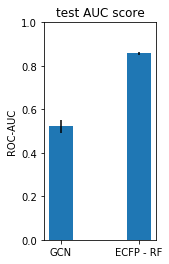

In [0]:
GCN_mean = np.mean(np.array(GCN_AUC_list))
GCN_std = np.std(np.array(GCN_AUC_list))

ECFP_mean = np.mean(np.array(ECFP_AUC_list))
ECFP_std = np.std(np.array(ECFP_AUC_list))


fig = plt.figure(figsize=(2, 4))
plt.title("test AUC score")
y = [GCN_mean, ECFP_mean]
x = ['GCN', 'ECFP - RF']
plt.bar(x, y, width=0.3, yerr = [GCN_std, ECFP_std])
plt.ylim((0, 1))
plt.ylabel("ROC-AUC")
plt.show()